# Importing necesessary modules


In [ ]:
from torch import nn
import torch
from tqdm.auto import tqdm
try:
  import torchmetrics
except ModuleNotFoundError:
  !pip install torchmetrics
import matplotlib.pyplot as plt

# Setting device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Downloading training and testing data if needed, setting dataloaders

The data consits of grayscale images 28 by 28 pixels

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from pathlib import Path
import os

dataset_dir = './data'
if not Path(dataset_dir).is_dir():
  os.mkdir(dataset_dir)

train_data = datasets.FashionMNIST(root=dataset_dir, train=True,
                                   download=not Path('./data/FashionMNIST').is_dir(), target_transform=None,
                                   transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root=dataset_dir, train=False,
                                   download=not Path('./data/FashionMNIST').is_dir(), target_transform=None,
                                   transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

Showing the first 10 images of the training dataset with matplotlib:

In this dataset there are 10 classes of different clothes items: T-shirt/top; Trouser; Pullover; Dress; Coat; Sandal; Shirt; Sneaker; Bag; Ankle boot
Training dataset consists of 60000 images; Testing dataset consists of 10000 images



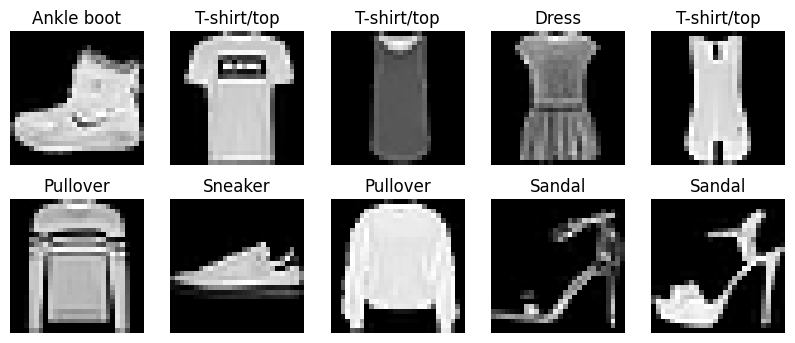

In [ ]:
class_names = train_data.classes
print(f'In this dataset there are {len(class_names)} classes of different clothes items: {"; ".join(class_names)}')
print(f'Training dataset consists of {len(train_data)} images; Testing dataset consists of {len(test_data)} images\n')

fig = plt.figure(figsize=(10, 4))
rows, cols = 2, 5
for i in range(1, rows * cols + 1):
    img, label = train_data[i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Creating the first model by subclassing `nn.Module`
Defining hyperparameters, optimizer, loss function and accuracy function for this model

In [ ]:
NUM_CLASSES = len(train_data.classes) # len(train_data.classes) = 10
HIDDEN_UNITS = 10
class FashionMNISTModel_v1(nn.Module):      #first version
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

model_1 = FashionMNISTModel_v1(input_shape=28*28, hidden_units=HIDDEN_UNITS, output_shape=NUM_CLASSES).to(device)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy_fn_1 = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

# Defining functions for training and testing step

In [ ]:
def train_step(model, dataloader, optimizer, loss_fn, accuracy_fn, device=device):
    average_acc = 0
    average_loss = 0
    model.train()
    for batch, (image, target) in enumerate(dataloader):
        image = image.to(device)
        target = target.to(device)

        logits = model(image)
        preds = logits.argmax(dim=1)
        loss = loss_fn(logits, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        average_acc += accuracy_fn(target, preds).item()
        average_loss += loss

    average_acc /= len(dataloader)
    average_loss /= len(dataloader)
    print (f'average train accuracy: {average_acc*100:.2f}%')
    print (f'average train loss: {average_loss:.3f}')

def test_step(model, dataloader, loss_fn, accuracy_fn, device=device):
    average_acc = 0
    average_loss = 0
    model.eval()
    with torch.inference_mode():
        for image, target in dataloader:
            image = image.to(device)
            target = target.to(device)

            logits = model(image)
            preds = logits.argmax(dim=1)

            average_acc += accuracy_fn(target, preds)
            average_loss += loss_fn(logits, target)
        average_acc /= len(dataloader)
        average_loss /= len(dataloader)
    print (f'average test accuracy: {average_acc*100:.2f}%')
    print (f'average test loss: {average_loss:.3f}')

# Training and testing the first model

In [ ]:
epochs = 10
for epoch in tqdm(range(1, epochs+1)):
    print(f'epoch {epoch}')
    train_step(model_1, train_dataloader, optimizer_1, loss_fn_1, accuracy_fn_1)
    test_step(model_1, test_dataloader, loss_fn_1, accuracy_fn_1)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1
average train accuracy: 69.75%
average train loss: 0.850
average test accuracy: 80.63%
average test loss: 0.562
epoch 2
average train accuracy: 82.96%
average train loss: 0.481
average test accuracy: 82.11%
average test loss: 0.513
epoch 3
average train accuracy: 84.06%
average train loss: 0.447
average test accuracy: 83.36%
average test loss: 0.462
epoch 4
average train accuracy: 84.64%
average train loss: 0.430
average test accuracy: 84.12%
average test loss: 0.452
epoch 5
average train accuracy: 85.02%
average train loss: 0.415
average test accuracy: 83.77%
average test loss: 0.453
epoch 6
average train accuracy: 85.32%
average train loss: 0.409
average test accuracy: 84.49%
average test loss: 0.440
epoch 7
average train accuracy: 85.64%
average train loss: 0.401
average test accuracy: 84.36%
average test loss: 0.445
epoch 8
average train accuracy: 85.66%
average train loss: 0.396
average test accuracy: 84.33%
average test loss: 0.436
epoch 9
average train accuracy: 85.80%
a

# Creating the second model using CNN with tiny VGG architecture
Defining hyperparameters, optimizer, loss function and accuracy function for this model

In [ ]:
NUM_CLASSES = len(train_data.classes) # len(train_data.classes) = 10
HIDDEN_UNITS = 10
classifier_input = int((28/2/2)**2 * HIDDEN_UNITS)

class FashionMNISTModel_v2(nn.Module):      #tiny VGG architecure
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=classifier_input, out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

model_2 = FashionMNISTModel_v2(input_shape=1, hidden_units=HIDDEN_UNITS, output_shape=NUM_CLASSES).to(device)

loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
accuracy_fn_2 = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

# Training and testing the second model

In [ ]:
epochs = 20
for epoch in tqdm(range(1, epochs+1)):
    print(f'epoch {epoch}')
    train_step(model_2, train_dataloader, optimizer_2, loss_fn_2, accuracy_fn_2)
    test_step(model_2, test_dataloader, loss_fn_2, accuracy_fn_2)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 1
average train accuracy: 76.99%
average train loss: 0.626
average test accuracy: 86.88%
average test loss: 0.367
epoch 2
average train accuracy: 87.80%
average train loss: 0.343
average test accuracy: 87.11%
average test loss: 0.347
epoch 3
average train accuracy: 89.07%
average train loss: 0.303
average test accuracy: 88.40%
average test loss: 0.322
epoch 4
average train accuracy: 89.76%
average train loss: 0.283
average test accuracy: 88.77%
average test loss: 0.314
epoch 5
average train accuracy: 90.14%
average train loss: 0.271
average test accuracy: 88.73%
average test loss: 0.302
epoch 6
average train accuracy: 90.58%
average train loss: 0.260
average test accuracy: 88.71%
average test loss: 0.315
epoch 7
average train accuracy: 90.83%
average train loss: 0.252
average test accuracy: 89.70%
average test loss: 0.284
epoch 8
average train accuracy: 90.98%
average train loss: 0.247
average test accuracy: 90.01%
average test loss: 0.282
epoch 9
average train accuracy: 91.06%
a

# Saving a model

In [ ]:
from pathlib import Path
import os

MODEL_NAME = 'pytorch_FashionMNIST_model.pth'
MODEL_PATH = 'models'
if not Path(MODEL_PATH).is_dir():
  os.mkdir(MODEL_PATH)

MODEL_SAVE_PATH = MODEL_PATH + '/' + MODEL_NAME


In [ ]:
torch.save(model_2.state_dict(), MODEL_SAVE_PATH)

# Loading a model


In [ ]:
loaded_model = FashionMNISTModel_v2(input_shape=1, hidden_units=HIDDEN_UNITS, output_shape=NUM_CLASSES).to(device)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True, map_location=torch.device(device)))


<All keys matched successfully>

# Evaluating a model

### Plotting random predictions

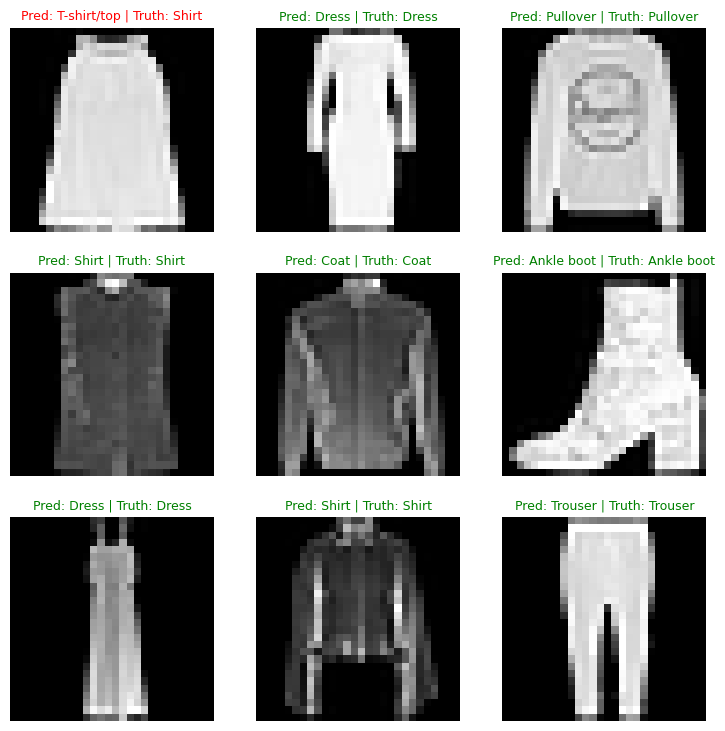

In [ ]:
import random

def plot_predictions(model, test_data):
  sample = random.sample(list(test_data), k=9)
  plt.figure(figsize=(9, 9))
  rows = 3
  cols = 3
  model.eval()
  with torch.inference_mode():
    for i, (img, label) in enumerate(sample):
      plt.subplot(rows, cols, i+1)
      plt.imshow(img.squeeze(), cmap="gray")

      img = img.to(device)
      pred = model(img.unsqueeze(dim=0)).argmax(dim=1)
      pred_label = class_names[pred]

      truth_label = class_names[label]

      title_text = f"Pred: {pred_label} | Truth: {truth_label}"

      if pred_label == truth_label:
          plt.title(title_text, fontsize=9, c="g")
      else:
          plt.title(title_text, fontsize=9, c="r")
      plt.axis(False);

plot_predictions(loaded_model, test_data)

### Plotting some random images the model got wrong

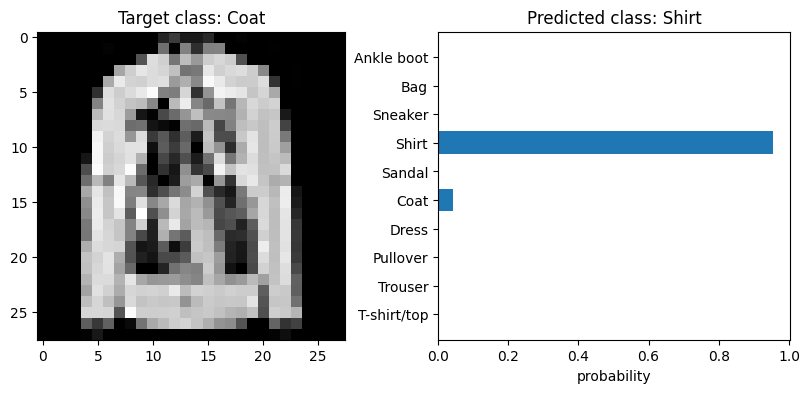

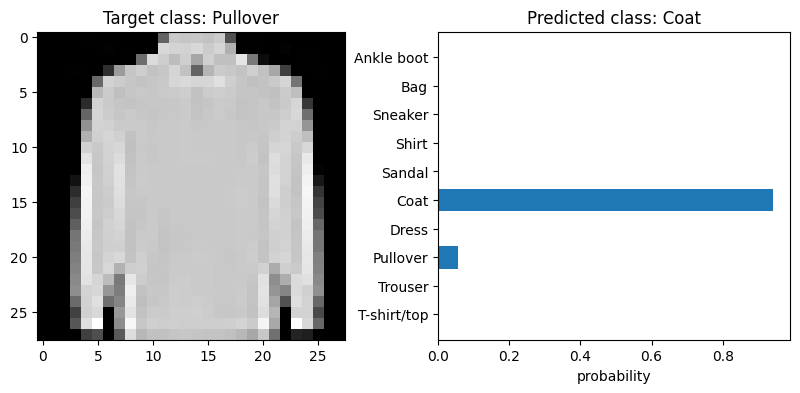

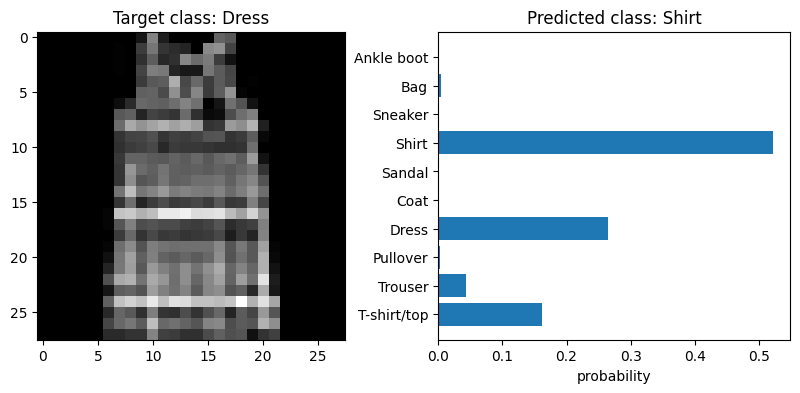

In [ ]:
import random

def rand_wrong_prediction(model, test_data):
  targets = test_data.targets
  class_names = test_data.classes

  predictions = []
  probabilities = []

  loaded_model.eval()
  with torch.inference_mode():
      for image, target in test_dataloader:
          image = image.to(device)
          target = target.to(device)

          logits = loaded_model(image)
          probs = torch.softmax(logits, dim=1)
          preds = logits.argmax(dim=1)
          predictions += torch.Tensor.tolist(preds)
          probabilities += torch.Tensor.tolist(probs)

  predictions = torch.tensor(predictions)
  wrong_preds_indices = torch.Tensor.tolist(torch.nonzero(torch.ne(predictions, targets)).squeeze())

  fig = plt.figure(figsize=(10, 4))
  wrong_idx = random.choice(wrong_preds_indices)
  fig.add_subplot(1, 2, 1)
  img = test_data.data[wrong_idx]
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f'Target class: {class_names[targets[wrong_idx]]}')

  probs = probabilities[wrong_idx]
  fig.add_subplot(1, 2, 2)

  plt.barh(class_names, probs)
  plt.xlabel("probability")
  plt.ylabel("classes")
  plt.title(f'Predicted class: {class_names[predictions[wrong_idx]]}')

for i in range(3):
  rand_wrong_prediction(loaded_model, test_data)


